In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json

from prettytable import PrettyTable

# Individual Model Evaluation

In [99]:
evaluation_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json'


In [100]:
def plot_trigger_scores(data):
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df[['precision', 'recall', 'f1']]
    df = df.reset_index().melt(id_vars=['index'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = [(0, 0.447, 0.698), (0.863, 0.373, 0.294), (0.275, 0.529, 0.204)]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='score', y='value', hue='index', data=df, palette=colors)
    plt.legend(title='Dataset')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Datasets")
    plt.show()

    table = PrettyTable()
    table.field_names = ['Dataset', 'Recall', 'Precision', 'F1']
    for dataset, scores in data.items():
        table.add_row([dataset, float(scores['recall']), float(scores['precision']), float(scores['f1'])])
    print(table)

In [101]:
def plot_auc_scores(data, datasets):
    _, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i, dataset in enumerate(datasets):
        auc_scores_raw = data[dataset]['class_auc']
        auc_scores = {'mean_auc': data[dataset]['auc']}
        auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in auc_scores_raw.items()}

        df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC Score'])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Class'}, inplace=True)

        sns.set_palette("husl", len(df))
        sns.set(style="darkgrid", palette="husl", rc={"axes.facecolor": (0, 0, 0, 0)})
        sns.barplot(x='Class', y='AUC Score', data=df, ax=axs[i])

        axs[i].axhline(y=0.9828, color='r', linestyle='--', label='Detoxify Baseline (0.9828)')
        axs[i].set(xlabel='Class', ylabel='AUC Score', title=f'AUC Scores per Class for {dataset}')
        axs[i].set_ylim(0.5, 1)
        legend = axs[i].legend(loc='lower right')
        legend.get_frame().set_facecolor('w')

    plt.tight_layout()
    plt.show()

In [102]:
def table_roc_auc_scores(jigsaw_raw, secondary_neutral_raw):
    jigsaw_auc_scores = {'mean_auc': jigsaw_raw['auc']}
    jigsaw_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in jigsaw_raw['class_auc'].items()}

    secondary_neutral_auc_scores = {'mean_auc': secondary_neutral_raw['auc']}
    secondary_neutral_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in secondary_neutral_raw['class_auc'].items()}
    
    table = PrettyTable()
    table.field_names = ['Class', 'Jigsaw', 'Secondary Neutral']
    for class_label in jigsaw_auc_scores.keys():
        table.add_row([class_label, round(jigsaw_auc_scores[class_label], 4), round(secondary_neutral_auc_scores[class_label], 4)])
    print(table)

In [103]:
def plot_all_data(data):
    plot_trigger_scores(data)
    plot_auc_scores(data, ['jigsaw', 'secondary_neutral'])
    table_roc_auc_scores(data['jigsaw'], data['secondary_neutral'])

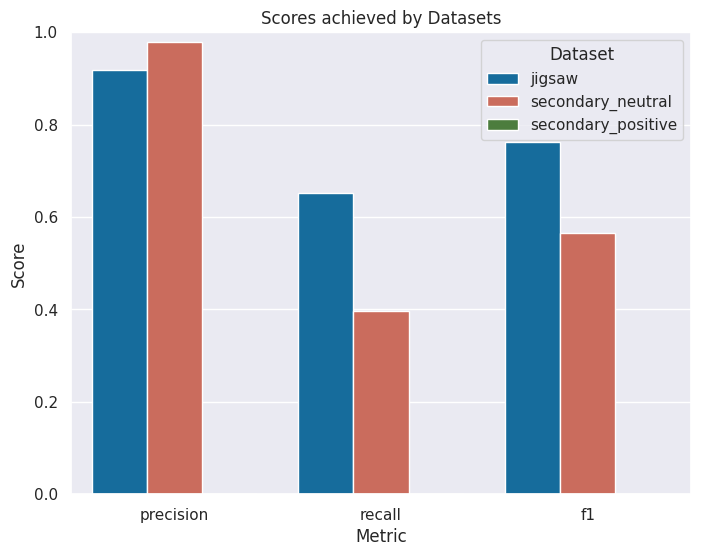

+--------------------+--------+-----------+--------+
|      Dataset       | Recall | Precision |   F1   |
+--------------------+--------+-----------+--------+
|       jigsaw       | 0.6525 |   0.9181  | 0.7628 |
| secondary_neutral  | 0.3977 |   0.9791  | 0.5656 |
| secondary_positive |  0.0   |    0.0    |  0.0   |
+--------------------+--------+-----------+--------+


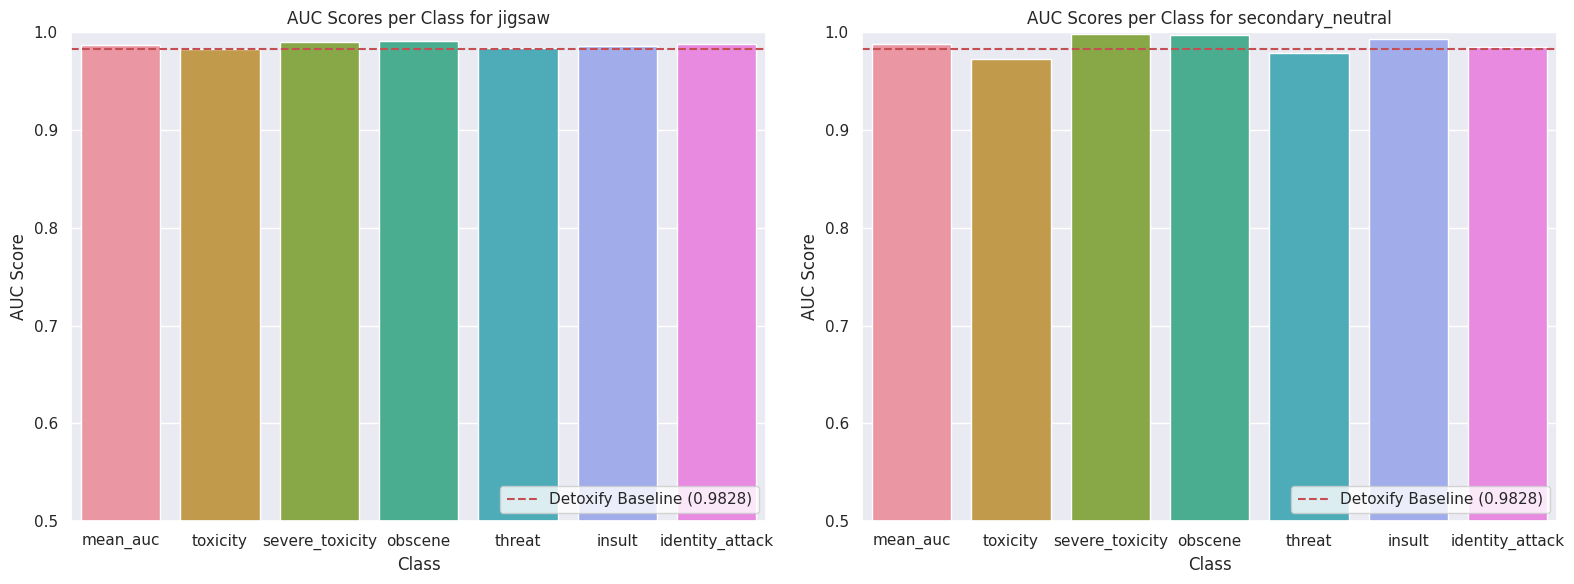

+-----------------+--------+-------------------+
|      Class      | Jigsaw | Secondary Neutral |
+-----------------+--------+-------------------+
|     mean_auc    | 0.9871 |       0.9876      |
|     toxicity    | 0.9831 |       0.9729      |
| severe_toxicity | 0.9905 |       0.9983      |
|     obscene     | 0.9912 |       0.9977      |
|      threat     | 0.984  |       0.9784      |
|      insult     | 0.9859 |       0.9935      |
| identity_attack | 0.9881 |       0.9849      |
+-----------------+--------+-------------------+


In [104]:
with open(evaluation_data, 'r') as f:
    data = json.load(f)
plot_all_data(data)


In [84]:
def confusion_matrix(confusion_dict):
    table = PrettyTable()
    table.field_names = ['', 'Actual Positive', 'Actual Negative']
    
    table.add_row(['Predicted Positive', confusion_dict['tp'], confusion_dict['fp']])
    table.add_row(['Predicted Negative', confusion_dict['fn'], confusion_dict['tn']])
    
    print(table)

In [85]:
confusion_matrix_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json'
with open(confusion_matrix_data, 'r') as f:
    data = json.load(f)

confusion_data = data['secondary_positive']['confusion_matrix']
confusion_matrix(confusion_data)

+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |       243       |        0        |
| Predicted Negative |        9        |        0        |
+--------------------+-----------------+-----------------+


# Model Data Ratio Investigation

In [105]:
ratio_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
    "100:5:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json',
    "100:10:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-10/checkpoints/converted/epoch=0-step=3577_test_results.json',
    "100:20:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-20-10/checkpoints/converted/epoch=0-step=3875_test_results.json',
    '100:100:1': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=0-step=11233_test_results.json',
    "100:100:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-5/checkpoints/converted/epoch=2-step=34368_test_results.json',
    "100:100:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-10/checkpoints/converted/epoch=0-step=11736_test_results.json',
    "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-100/checkpoints/converted/epoch=0-step=8942_test_results.json'
}

In [106]:
def plot_ratio_scores(df, dataset):
    df_melt = df.melt(id_vars=['Ratio'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette("bright", n_colors=len(df_melt['Ratio'].unique()))

    g = sns.catplot(x='score', y='value', hue='Ratio', data=df_melt, kind='bar', palette=colors,
                sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Dataset Ratios', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title(f"{dataset} Scores achieved by Different Dataset Ratios - Jigsaw:Secondary Neutral:Secondary Positive")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Ratio', 'Recall', 'Precision', 'F1']
    for _, row in df.iterrows():
        table.add_row([row['Ratio'], row['Recall'], row['Precision'], row['F1']])
    print(table)

In [107]:
dataset = 'secondary_neutral'
dataset_name = " ".join([w[0].upper() + w[1:] for w in dataset.split("_")])
final_df = pd.DataFrame()
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)[dataset]
        df = pd.DataFrame.from_dict(data, orient='index').transpose()
        df = df.loc[:, ['precision', 'recall', 'f1']]
        df['ratio'] = ratio
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df = final_df.rename(columns={
    'recall': 'Recall',
    'precision': 'Precision',
    'f1': 'F1',
    'ratio': 'Ratio'
})

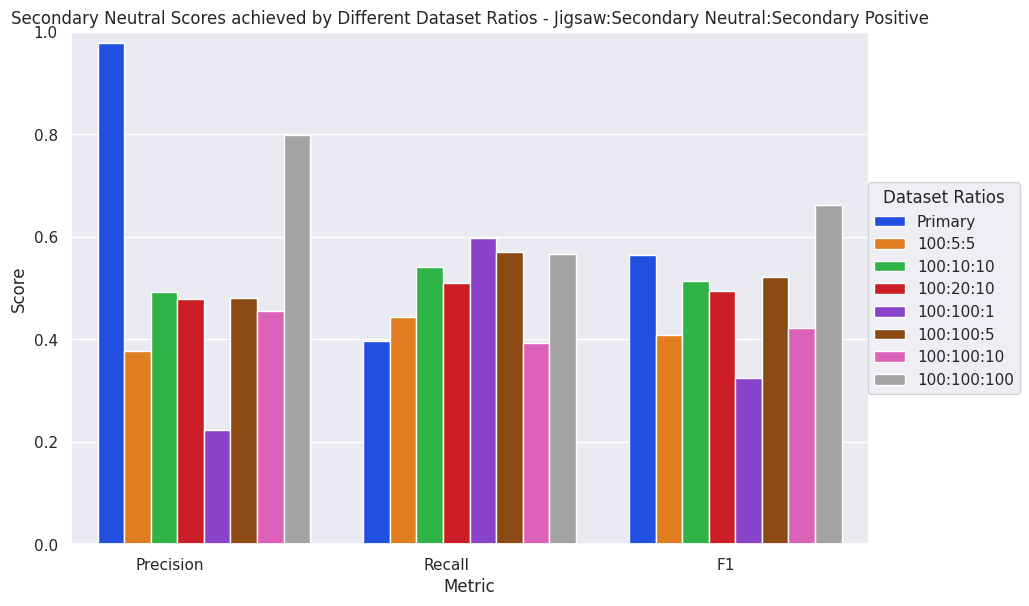

+-------------+--------+-----------+--------+
|    Ratio    | Recall | Precision |   F1   |
+-------------+--------+-----------+--------+
|   Primary   | 0.3977 |   0.9791  | 0.5656 |
|   100:5:5   | 0.443  |   0.378   | 0.408  |
|  100:10:10  | 0.5403 |   0.4915  | 0.5147 |
|  100:20:10  | 0.5104 |   0.479   | 0.4942 |
|  100:100:1  | 0.5981 |   0.2233  | 0.3252 |
|  100:100:5  | 0.5712 |   0.4803  | 0.5218 |
|  100:100:10 | 0.3925 |   0.4562  | 0.422  |
| 100:100:100 | 0.5658 |   0.7986  | 0.6624 |
+-------------+--------+-----------+--------+


In [108]:
plot_ratio_scores(final_df, dataset=dataset_name)


In [109]:
datasets = ["jigsaw", "secondary_neutral", "secondary_positive"]
final_df = pd.DataFrame(columns=["Ratio", "Precision", "Recall", "F1"])
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)
        f1, precision, recall = [], [], []
        for dataset in datasets:
            d = data[dataset]
            f1.append(d['f1'])
            precision.append(d['precision'])
            recall.append(d['recall'])
        f1 = "{:5.4f} {:5.4f} {:5.4f}".format(*f1)
        precision = "{:5.4f} {:5.4f} {:5.4f}".format(*precision)
        recall = "{:5.4f} {:5.4f} {:5.4f}".format(*recall)
        new_row = {
            "Ratio": ratio, 
            "Precision (Jigsaw)": f1,
            "Recall (Jigsaw)": precision, 
            "F1 (Jigsaw)": recall
        }
    final_df = pd.concat([final_df, pd.DataFrame([new_row])], ignore_index=True)

In [110]:
datasets = [("jigsaw", "J"), ("secondary_neutral", "SN"), ("secondary_positive", "SP")]
final_df = pd.DataFrame(columns=["Ratio", "Precision (J)", "Recall (J)", "F1 (J)", "Precision (SN)",
                        "Recall (SN)", "F1 (SN)", "Precision (SP)", "Recall (SP)", "F1 (SP)"])
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)
        new_row = {
            "Ratio": ratio,
        }
        for (dataset, acronym) in datasets:
            d = data[dataset]
            new_row |= {
                f"Precision ({acronym})": "{:1.4f}".format(d['precision']),
                f"Recall ({acronym})": "{:1.4f}".format(d['recall']),
                f"F1 ({acronym})": "{:1.4f}".format(d['f1'])
            }

    final_df = pd.concat(
        [final_df, pd.DataFrame([new_row])], ignore_index=True)

In [111]:
def table_ratio_results(table_data):
    table = PrettyTable()
    table.field_names = ['Ratio', "Precision (J)", "Recall (J)", "F1 (J)", "Precision (SN)",
                         "Recall (SN)", "F1 (SN)", "Precision (SP)", "Recall (SP)", "F1 (SP)"]
    for _, row in table_data.iterrows():
        table.add_row([
            row['Ratio'],
            row['Precision (J)'],
            row['Recall (J)'],
            row['F1 (J)'],
            row['Precision (SN)'],
            row['Recall (SN)'],
            row['F1 (SN)'],
            row['Precision (SP)'],
            row['Recall (SP)'],
            row['F1 (SP)']
        ])
    print("Scores achieved by the three datasets: Jigsaw - Secondary Neutral - Secondary Positive")
    print(table)
    print("Key: J = Jigsaw | SN = Secondary Neutral | SP = Secondary Positive")

In [112]:
def highlight_max(s):
    if s.name == "Ratio":
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: teal' if cell else '' for cell in is_max]
  
final_df.style.apply(highlight_max)

,Ratio,Precision (J),Recall (J),F1 (J),Precision (SN),Recall (SN),F1 (SN),Precision (SP),Recall (SP),F1 (SP)
0,Primary,0.9181,0.6525,0.7628,0.9791,0.3977,0.5656,0.0000,0.0000,0.0000
1,100:5:5,0.9141,0.6386,0.7519,0.3780,0.4430,0.4080,1.0000,0.9643,0.9818
2,100:10:10,0.9099,0.6561,0.7624,0.4915,0.5403,0.5147,1.0000,0.9563,0.9777
3,100:20:10,0.9067,0.6399,0.7503,0.4790,0.5104,0.4942,1.0000,0.9722,0.9859
4,100:100:1,0.9167,0.6014,0.7263,0.2233,0.5981,0.3252,1.0000,0.9921,0.9960
5,100:100:5,0.9016,0.6771,0.7734,0.4803,0.5712,0.5218,1.0000,0.9325,0.9651
6,100:100:10,0.9051,0.5849,0.7106,0.4562,0.3925,0.4220,1.0000,0.8016,0.8899
7,100:100:100,0.9164,0.6140,0.7353,0.7986,0.5658,0.6624,1.0000,0.8016,0.8899


In [113]:
table_ratio_results(final_df)

Scores achieved by the three datasets: Jigsaw - Secondary Neutral - Secondary Positive
+-------------+---------------+------------+--------+----------------+-------------+---------+----------------+-------------+---------+
|    Ratio    | Precision (J) | Recall (J) | F1 (J) | Precision (SN) | Recall (SN) | F1 (SN) | Precision (SP) | Recall (SP) | F1 (SP) |
+-------------+---------------+------------+--------+----------------+-------------+---------+----------------+-------------+---------+
|   Primary   |     0.9181    |   0.6525   | 0.7628 |     0.9791     |    0.3977   |  0.5656 |     0.0000     |    0.0000   |  0.0000 |
|   100:5:5   |     0.9141    |   0.6386   | 0.7519 |     0.3780     |    0.4430   |  0.4080 |     1.0000     |    0.9643   |  0.9818 |
|  100:10:10  |     0.9099    |   0.6561   | 0.7624 |     0.4915     |    0.5403   |  0.5147 |     1.0000     |    0.9563   |  0.9777 |
|  100:20:10  |     0.9067    |   0.6399   | 0.7503 |     0.4790     |    0.5104   |  0.4942 |   

# Primary vs Secondary Model Investigation

In [114]:
model_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
    "Secondary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/version_0/checkpoints/converted/epoch=2_test_results.json',
}

In [115]:
def compare_primary_secondary(df):
    df_melt = df.melt(id_vars=['Model'], var_name='score', value_name='value')
    df_melt['value'] = pd.to_numeric(df_melt['value'])

    sns.set(style="darkgrid")
    colors = sns.color_palette("husl", n_colors=len(df_melt['Model'].unique()))

    g = sns.catplot(x='score', y='value', hue='Model', data=df_melt, kind='bar', palette=colors,
                    sharey=False, aspect=1.5, height=6, errorbar=None, dodge=True)

    # Add vertical dotted line every 3 groups of bars
    for i in range(3, len(df_melt['score'].unique()), 3):
        plt.axvline(x=i-0.5, linestyle='--', color='gray')

    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Models', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Models")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


In [116]:
datasets = [("jigsaw", "J"), ("secondary_neutral", "SN"), ("secondary_positive", "SP")]
final_df = pd.DataFrame(columns=["Model", "Precision (J)", "Recall (J)", "F1 (J)", "Precision (SN)",
                        "Recall (SN)", "F1 (SN)", "Precision (SP)", "Recall (SP)", "F1 (SP)"])
for model, model_path in model_paths.items():
    with open(model_path, 'r') as f:
        data = json.load(f)
        new_row = {
            "Model": model,
        }
        for (dataset, acronym) in datasets:
            d = data[dataset]
            new_row |= {
                f"Precision ({acronym})": "{:1.4f}".format(d['precision']),
                f"Recall ({acronym})": "{:1.4f}".format(d['recall']),
                f"F1 ({acronym})": "{:1.4f}".format(d['f1'])
            }

    final_df = pd.concat(
        [final_df, pd.DataFrame([new_row])], ignore_index=True)

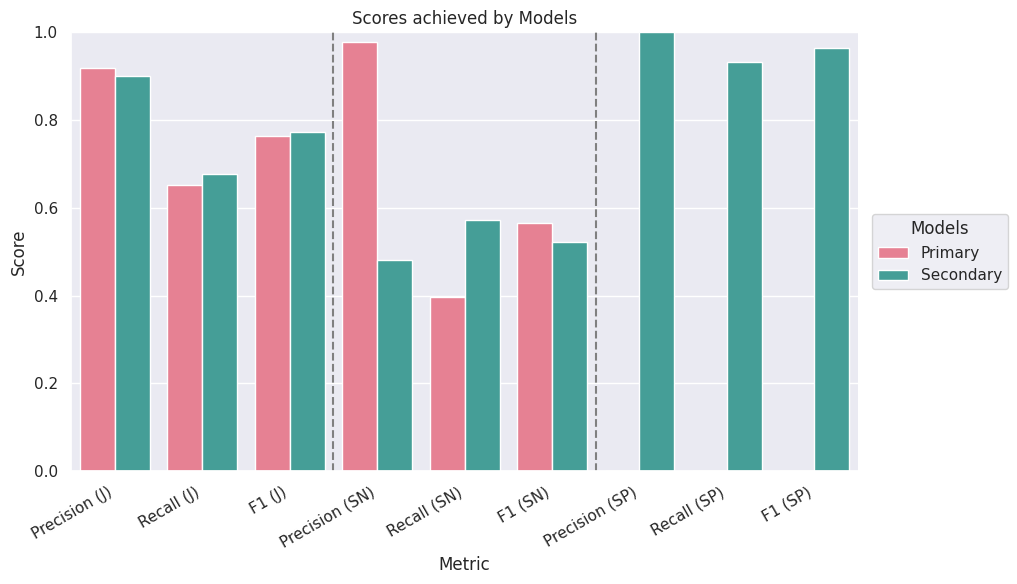

,Model,Precision (J),Recall (J),F1 (J),Precision (SN),Recall (SN),F1 (SN),Precision (SP),Recall (SP),F1 (SP)
0,Primary,0.9181,0.6525,0.7628,0.9791,0.3977,0.5656,0.0000,0.0000,0.0000
1,Secondary,0.9016,0.6771,0.7734,0.4803,0.5712,0.5218,1.0000,0.9325,0.9651


In [117]:
def highlight_max(s):
    if s.name == "Model":
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: teal' if cell else '' for cell in is_max]
  
compare_primary_secondary(final_df)
final_df.style.apply(highlight_max)